In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, MultiLineString, Point
import matplotlib.pyplot as plt

from here_location_services import LS
from here_location_services.config.routing_config import ROUTING_RETURN
from here_map_widget import Map, Marker, GeoJSON

In [2]:
Citibike = pd.read_csv('./Data/CitiBike/202109-citibike-tripdata.csv')
Citibike

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A789BD2808767C24,classic_bike,2021-09-16 12:34:39,2021-09-16 12:36:05,Clinton St\t& Cherry St,5190.09,Madison St & Clinton St,5190.07,40.711471,-73.986726,40.712690,-73.987763,member
1,B3E45CE415FDF1E7,classic_bike,2021-09-28 20:36:25,2021-09-28 20:37:58,Clinton St & Grand St,5303.06,Madison St & Clinton St,5190.07,40.715595,-73.987030,40.712690,-73.987763,member
2,50433A2E1F35CBBB,classic_bike,2021-09-26 20:08:43,2021-09-26 20:25:36,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual
3,C478A0B3E61B504F,electric_bike,2021-09-06 18:25:20,2021-09-06 18:30:21,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual
4,2B82A80EECFC4458,electric_bike,2021-09-07 18:39:08,2021-09-07 18:54:03,E 65 St & 2 Ave,6860.12,28 St & 41 Ave,6462.19,40.764719,-73.962221,40.751047,-73.937970,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280555,720BBDEE43921F6D,classic_bike,2021-09-21 17:48:25,2021-09-21 18:08:46,E 11 St & 1 Ave,5746.14,Broadway & W 41 St,6560.01,40.729538,-73.984267,40.755136,-73.986580,member
3280556,4ED4E160CC1D1C65,classic_bike,2021-09-11 12:53:06,2021-09-11 13:08:40,3 Ave & E 72 St,7028.04,E 72 St & Park Ave,6998.08,40.769943,-73.960607,40.771183,-73.964094,member
3280557,E924ABF461609933,classic_bike,2021-09-18 13:36:50,2021-09-18 13:39:49,Broadway & W 36 St,6441.01,Broadway & W 41 St,6560.01,40.750977,-73.987654,40.755136,-73.986580,member
3280558,8A768D642836C58A,classic_bike,2021-09-10 23:36:49,2021-09-10 23:56:42,Grand St & Greene St,5500.02,Cherry St,5181.04,40.721700,-74.002381,40.712199,-73.979481,casual


In [3]:
Citibike.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id      float64
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [4]:
Citibike['start_station_id'] = pd.to_numeric(Citibike['start_station_id'])
Citibike['end_station_id'] = pd.to_numeric(Citibike['end_station_id'], errors='coerce')

In [5]:
Citibike = Citibike.dropna(subset=['start_station_id','end_station_id'])
len(Citibike)

3264737

## Get the sample bike stations

In [6]:
start_station = Citibike[['start_station_name','start_station_id','start_lat','start_lng']]
start_station.columns=['station_name','station_id','lat','lng']
start_station.head()

,station_name,station_id,lat,lng
0,Clinton St\t& Cherry St,5190.09,40.711471,-73.986726
1,Clinton St & Grand St,5303.06,40.715595,-73.987030
2,LaGuardia Pl & W 3 St,5721.14,40.729170,-73.998102
3,LaGuardia Pl & W 3 St,5721.14,40.729170,-73.998102
4,E 65 St & 2 Ave,6860.12,40.764719,-73.962221


In [7]:
end_station = Citibike[['end_station_name','end_station_id','end_lat','end_lng']]
end_station.columns=['station_name','station_id','lat','lng']
end_station.head()

,station_name,station_id,lat,lng
0,Madison St & Clinton St,5190.07,40.712690,-73.987763
1,Madison St & Clinton St,5190.07,40.712690,-73.987763
2,Greenwich Ave & Charles St,5914.08,40.735238,-74.000271
3,Greenwich Ave & Charles St,5914.08,40.735238,-74.000271
4,28 St & 41 Ave,6462.19,40.751047,-73.937970


In [8]:
Station = pd.concat([start_station,end_station])
len(Station)

6529474

In [9]:
sum(Station.station_id.isnull())

0

In [10]:
# 1488 unique stops
Station = Station.loc[~Station.duplicated(subset=['station_id'])].reset_index(drop=True)
len(Station)

1488

In [11]:
Station.describe()

,station_id,lat,lng
count,1488.000000,1488.000000,1488.000000
mean,6247.705746,40.753693,-73.953522
std,1591.975436,0.062124,0.035817
min,2733.030000,40.633385,-74.027472
25%,4897.287500,40.701888,-73.984525
50%,6445.535000,40.751553,-73.953196
75%,7729.072500,40.808632,-73.922416
max,8841.030000,40.882260,-73.881450


In [12]:
### Selecting stations only within the 4 boroughs (without staten island)

In [13]:
Nyc_boro = gpd.read_file('./Data/GeoBase/nybb_22b/nybb.shp').to_crs(4326)
Nyc_boro

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,325924.002076,1.623631e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,463277.240478,1.187189e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1,Manhattan,359103.151368,6.366058e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,728478.125489,1.934169e+09,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,888238.562635,3.041397e+09,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [14]:
Nyc_boro = Nyc_boro.iloc[1:]
Nyc_boro

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
1,2,Bronx,463277.240478,1.187189e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1,Manhattan,359103.151368,6.366058e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,728478.125489,1.934169e+09,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,888238.562635,3.041397e+09,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [15]:
Station_Geo = gpd.GeoDataFrame(Station, geometry=gpd.points_from_xy(Station.lng, Station.lat), crs=4326)
Station_Geo.head()

,station_name,station_id,lat,lng,geometry
0,Clinton St\t& Cherry St,5190.09,40.711471,-73.986726,POINT (-73.98673 40.71147)
1,Clinton St & Grand St,5303.06,40.715595,-73.987030,POINT (-73.98703 40.71560)
2,LaGuardia Pl & W 3 St,5721.14,40.729170,-73.998102,POINT (-73.99810 40.72917)
3,E 65 St & 2 Ave,6860.12,40.764719,-73.962221,POINT (-73.96222 40.76472)
4,10 Ave & W 14 St,6157.04,40.741982,-74.008316,POINT (-74.00832 40.74198)


In [16]:
Station_nyc = gpd.sjoin(Station_Geo, Nyc_boro, how="inner")
Station_nyc  = Station_nyc.loc[~Station_nyc.duplicated(subset=['station_id'])].reset_index(drop=True)
len(Station_nyc)

1488

In [17]:
Station_nyc

,station_name,station_id,lat,lng,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
0,Clinton St\t& Cherry St,5190.09,40.711471,-73.986726,POINT (-73.98673 40.71147),2,1,Manhattan,359103.151368,6.366058e+08
1,Clinton St & Grand St,5303.06,40.715595,-73.987030,POINT (-73.98703 40.71560),2,1,Manhattan,359103.151368,6.366058e+08
2,LaGuardia Pl & W 3 St,5721.14,40.729170,-73.998102,POINT (-73.99810 40.72917),2,1,Manhattan,359103.151368,6.366058e+08
3,E 65 St & 2 Ave,6860.12,40.764719,-73.962221,POINT (-73.96222 40.76472),2,1,Manhattan,359103.151368,6.366058e+08
4,10 Ave & W 14 St,6157.04,40.741982,-74.008316,POINT (-74.00832 40.74198),2,1,Manhattan,359103.151368,6.366058e+08
...,...,...,...,...,...,...,...,...,...,...
1483,Ogden Ave & W 164 St,8115.01,40.832812,-73.929372,POINT (-73.92937 40.83281),1,2,Bronx,463277.240478,1.187189e+09
1484,Morris Ave & E 171 St,8209.01,40.838990,-73.910900,POINT (-73.91090 40.83899),1,2,Bronx,463277.240478,1.187189e+09
1485,Jerome Ave & W 193 St,8619.02,40.866590,-73.897940,POINT (-73.89794 40.86659),1,2,Bronx,463277.240478,1.187189e+09
1486,Charlotte St & Boston Rd,8167.04,40.835877,-73.893143,POINT (-73.89314 40.83588),1,2,Bronx,463277.240478,1.187189e+09


<AxesSubplot:>

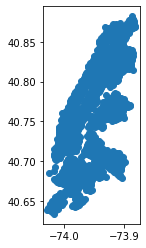

In [18]:
Station_nyc.plot()

In [19]:
Station_nyc.to_file('./Data/CitiBike/Station_nyc.geojson', driver='GeoJSON')

## BK bike

In [20]:
Nyc_bk = Nyc_boro.loc[Nyc_boro['BoroName'] == 'Brooklyn']
Nyc_bk

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
3,3,Brooklyn,728478.125489,1.934169e+09,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."


In [21]:
Nyc_boro.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
Station_bk = gpd.sjoin(Station_Geo, Nyc_bk, how="inner")
Station_bk  = Station_bk .loc[~Station_bk.duplicated(subset=['station_id'])].reset_index(drop=True)
len(Station_bk)

464

In [23]:
sum(Station_bk.station_id.duplicated())

0

In [24]:
sum(Station_bk.station_id.isnull())

0

<AxesSubplot:>

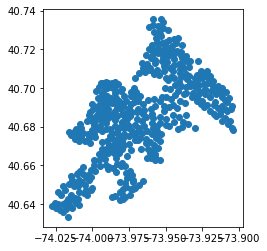

In [25]:
Station_bk.plot()

In [595]:
Station_bk.to_file('./Data/CitiBike/Station_bk.geojson', driver='GeoJSON')

# Estimate Bike Route

In [26]:
len(Citibike)

3264737

In [27]:
# keep trips within BK
CitibikeBK = Citibike.loc[(Citibike['start_station_id'].isin(Station_bk['station_id'])) & (Citibike['end_station_id'].isin(Station_bk['station_id']))]
len(CitibikeBK)

623966

In [28]:
# filter out round trips
CitibikeBK = CitibikeBK.loc[~(CitibikeBK['start_station_id'] == CitibikeBK['end_station_id'])].reset_index(drop=True)
len(CitibikeBK)

589047

In [29]:
CitibikeBK = CitibikeBK.dropna(subset=['start_station_id','end_station_id']).reset_index(drop=True)
len(CitibikeBK)

589047

## Broolyn

In [31]:
import osmnx as ox
import networkx as nx

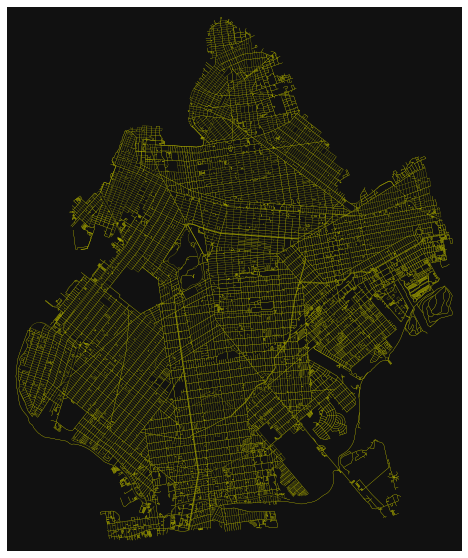

In [360]:
# creat base ox map


# The place where your 2 points are located. It will be used to create a graph from the OSM data
# In this example, the 2 points are two addresses in Manhattan, so we choose "Manhattan"
# It could be a bounding box too, or an area around a point
graph_area = ("Brooklyn, New York, USA")

# Create the graph of the area from OSM data. It will download the data and create the graph
G = ox.graph_from_place(graph_area, network_type='bike',retain_all=False)
G = ox.utils_graph.get_largest_component(G, strongly=True)

# OSM data are sometime incomplete so we use the speed module of osmnx to add missing edge speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Save graph to disk if you want to reuse it
ox.save_graphml(G, "Brooklyn.graphml")

# Load the graph
#G = ox.load_graphml("NYC.graphml")

# Plot the graph
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

In [600]:
# assign bike stops to network node
import time
start_time = time.time()

Station_bk = Station_bk.reset_index(drop=True)
# In the graph, get the nodes closest to the points

station_node=[]
for i in range(len(Station_bk)):
    station_node.append(ox.distance.nearest_nodes(G, Station_bk['lng'][i],Station_bk['lat'][i]))

end_time = time.time()
print(int((end_time-start_time)/60))

0


In [601]:
bk_nodes = pd.concat([Station_bk[['station_id']], pd.DataFrame(station_node)], axis=1).rename(columns={0:'OSMID'})
bk_nodes

,station_id,OSMID
0,5187.03,7976681097
1,4010.13,42491642
2,4151.01,42475949
3,5752.07,42520808
4,5267.08,42480109
...,...,...
459,3046.03,42497281
460,4128.08,42469874
461,2961.05,2620907650
462,4045.01,42471035


In [604]:
bk_nodes.station_id = bk_nodes.station_id.astype(float)
CitibikeBK.start_station_id = CitibikeBK.start_station_id.astype(float)
CitibikeBK.end_station_id = CitibikeBK.end_station_id.astype(float)

In [605]:
len(CitibikeBK)

589047

In [607]:
CitibikeBK_OSM = pd.merge(CitibikeBK, bk_nodes, left_on='start_station_id' ,right_on='station_id', how='left').rename(columns={'OSMID':'start_OSMID'}).drop(columns=['station_id'])
CitibikeBK_OSM = pd.merge(CitibikeBK_OSM, bk_nodes, left_on='end_station_id' ,right_on='station_id', how='left').rename(columns={'OSMID':'end_OSMID'}).drop(columns=['station_id'])
CitibikeBK_OSM

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_OSMID,end_OSMID
0,B0F6492DB3FABE11,classic_bike,2021-09-14 18:08:17,2021-09-14 18:13:53,Hope St & Union Ave,5187.03,Graham Ave & Conselyea St,5291.05,40.711674,-73.951413,40.715143,-73.944507,member,7976681097,42467880
1,722FE848B08F49E3,classic_bike,2021-09-06 16:57:56,2021-09-06 17:21:20,Hope St & Union Ave,5187.03,Verona Pl & Fulton St,4124.04,40.711674,-73.951413,40.680356,-73.947679,casual,7976681097,42464977
2,DC4BFDFE2CAF38C1,classic_bike,2021-09-24 20:09:26,2021-09-24 20:14:32,Hope St & Union Ave,5187.03,Graham Ave & Conselyea St,5291.05,40.711674,-73.951413,40.715143,-73.944507,casual,7976681097,42467880
3,A046D65ABE2B7027,electric_bike,2021-09-03 19:14:22,2021-09-03 19:41:42,Plaza St West & Flatbush Ave,4010.13,Franklin St & Dupont St,5944.01,40.675021,-73.971115,40.735640,-73.958660,member,42491642,42520827
4,64E4FC9323C492A0,classic_bike,2021-09-08 08:50:15,2021-09-08 08:56:04,Hope St & Union Ave,5187.03,Bayard St & Leonard St,5442.05,40.711674,-73.951413,40.719156,-73.948854,member,7976681097,42491220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589042,42FD63FEB3C9747F,classic_bike,2021-09-13 13:25:53,2021-09-13 13:32:30,Sands St & Jay St,4821.03,Flushing Ave & Vanderbilt Ave,4762.05,40.700119,-73.986200,40.697950,-73.970776,casual,494509169,9301030699
589043,BA06DEB6B7F95834,classic_bike,2021-09-10 16:40:14,2021-09-10 16:56:06,Montague St & Clinton St,4677.06,Flushing Ave & Vanderbilt Ave,4762.05,40.694271,-73.992327,40.697950,-73.970776,member,42485643,9301030699
589044,F026474158E1F924,electric_bike,2021-09-15 18:18:53,2021-09-15 18:35:19,Kingston Ave & Herkimer St,4205.06,Bedford Ave & Montgomery St,3736.03,40.678907,-73.941428,40.665816,-73.956934,casual,42467425,42479610
589045,8852F5990403419E,electric_bike,2021-09-12 19:45:04,2021-09-12 20:24:14,Prospect Park SW & 10 Ave,3611.02,Central Ave & Starr Street,4792.03,40.659945,-73.977504,40.700003,-73.928340,casual,1691133774,42486718


In [640]:
CitibikeBK_OSM.to_csv('./Data/Citibike/CitibikeBK_OSM.csv')

In [632]:
import time
Routes_1 = []
nodes = ox.graph_to_gdfs(G, edges=False)

start_time = time.time()

for i in range(0,len(CitibikeBK_OSM)):
    route_nodes = nodes.loc[nx.shortest_path(G, CitibikeBK_OSM['start_OSMID'][i], CitibikeBK_OSM['end_OSMID'][i])]
    path = LineString(list(route_nodes.geometry.values))
    Route = gpd.GeoSeries(path)
    Routes.append(Route)
    
    if i%50000 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60))

0
1
2
3
4
5
6
7
8
9
10
11


In [635]:
aa = gpd.GeoDataFrame(pd.DataFrame(Routes), geometry=pd.DataFrame(Routes)[0])
aa = aa.drop(columns=[0])

In [639]:
aa.to_file('./Data/CitiBike/Route_bk.geojson', driver='GeoJSON')

## NYC

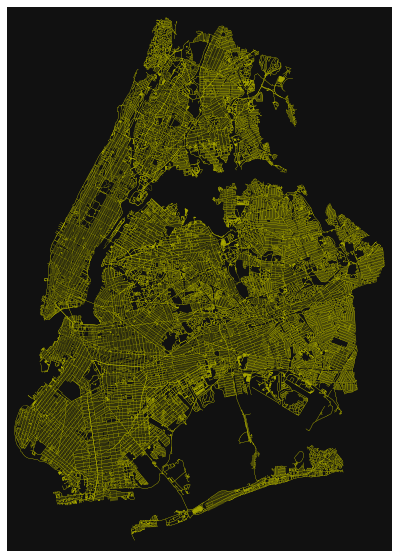

In [641]:
# creat base ox map


# The place where your 2 points are located. It will be used to create a graph from the OSM data
# In this example, the 2 points are two addresses in Manhattan, so we choose "Manhattan"
# It could be a bounding box too, or an area around a point
graph_area = ("New York, USA")

# Create the graph of the area from OSM data. It will download the data and create the graph
G = ox.graph_from_place(graph_area, network_type='bike',retain_all=False)
G = ox.utils_graph.get_largest_component(G, strongly=True)

# OSM data are sometime incomplete so we use the speed module of osmnx to add missing edge speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Save graph to disk if you want to reuse it
ox.save_graphml(G, "NYC.graphml")

# Load the graph
#G = ox.load_graphml("NYC.graphml")

# Plot the graph
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

In [32]:
G = ox.load_graphml("NYC.graphml")

In [667]:
# assign bike stops to network node
import time
start_time = time.time()

# In the graph, get the nodes closest to the points

station_node=[]
for i in range(len(Station_nyc)):
    station_node.append(ox.distance.nearest_nodes(G, Station_nyc['lng'][i],Station_nyc['lat'][i]))

end_time = time.time()
print(int((end_time-start_time)/60))

17


In [669]:
nyc_nodes = pd.concat([Station_nyc[['station_id']], pd.DataFrame(station_node)], axis=1).rename(columns={0:'OSMID'})
nyc_nodes

,station_id,OSMID
0,5190.09,42437503
1,5303.06,7595185930
2,5721.14,42440553
3,6860.12,8847352139
4,6157.04,42454328
...,...,...
1483,8115.01,42734276
1484,8209.01,5481864208
1485,8619.02,42736251
1486,8167.04,42751198


In [672]:
len(Citibike)

3264737

In [680]:
Citibike_OSM = pd.merge(Citibike, nyc_nodes, left_on='start_station_id' ,right_on='station_id', how='left').rename(columns={'OSMID':'start_OSMID'}).drop(columns=['station_id'])
Citibike_OSM = pd.merge(Citibike_OSM, nyc_nodes, left_on='end_station_id' ,right_on='station_id', how='left').rename(columns={'OSMID':'end_OSMID'}).drop(columns=['station_id'])
Citibike_OSM

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_OSMID,end_OSMID
0,A789BD2808767C24,classic_bike,2021-09-16 12:34:39,2021-09-16 12:36:05,Clinton St\t& Cherry St,5190.09,Madison St & Clinton St,5190.07,40.711471,-73.986726,40.712690,-73.987763,member,42437503,42437768
1,B3E45CE415FDF1E7,classic_bike,2021-09-28 20:36:25,2021-09-28 20:37:58,Clinton St & Grand St,5303.06,Madison St & Clinton St,5190.07,40.715595,-73.987030,40.712690,-73.987763,member,7595185930,42437768
2,50433A2E1F35CBBB,classic_bike,2021-09-26 20:08:43,2021-09-26 20:25:36,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199
3,C478A0B3E61B504F,electric_bike,2021-09-06 18:25:20,2021-09-06 18:30:21,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199
4,2B82A80EECFC4458,electric_bike,2021-09-07 18:39:08,2021-09-07 18:54:03,E 65 St & 2 Ave,6860.12,28 St & 41 Ave,6462.19,40.764719,-73.962221,40.751047,-73.937970,casual,8847352139,7103675571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264732,720BBDEE43921F6D,classic_bike,2021-09-21 17:48:25,2021-09-21 18:08:46,E 11 St & 1 Ave,5746.14,Broadway & W 41 St,6560.01,40.729538,-73.984267,40.755136,-73.986580,member,42454994,42428283
3264733,4ED4E160CC1D1C65,classic_bike,2021-09-11 12:53:06,2021-09-11 13:08:40,3 Ave & E 72 St,7028.04,E 72 St & Park Ave,6998.08,40.769943,-73.960607,40.771183,-73.964094,member,42436486,596776057
3264734,E924ABF461609933,classic_bike,2021-09-18 13:36:50,2021-09-18 13:39:49,Broadway & W 36 St,6441.01,Broadway & W 41 St,6560.01,40.750977,-73.987654,40.755136,-73.986580,member,42428253,42428283
3264735,8A768D642836C58A,classic_bike,2021-09-10 23:36:49,2021-09-10 23:56:42,Grand St & Greene St,5500.02,Cherry St,5181.04,40.721700,-74.002381,40.712199,-73.979481,casual,42452040,7499128088


In [683]:
sum(Citibike_OSM['start_OSMID'].isnull())

0

In [684]:
sum(Citibike_OSM['end_OSMID'].isnull())

0

In [681]:
# filter out round trips
Citibike_OSM = Citibike_OSM.loc[~(Citibike_OSM['start_OSMID'] == Citibike_OSM['end_OSMID'])].reset_index(drop=True)
len(Citibike_OSM)

3100729

In [685]:
Citibike_OSM.to_csv('./Data/Citibike/Citibike_OSM.csv')

In [33]:
Citibike_OSM = pd.read_csv('./Data/Citibike/Citibike_OSM.csv')

In [34]:
import time
Routes = []
nodes = ox.graph_to_gdfs(G, edges=False)

start_time = time.time()

for i in range(0,len(Citibike_OSM)):
    route_nodes = nodes.loc[nx.shortest_path(G, Citibike_OSM['start_OSMID'][i], Citibike_OSM['end_OSMID'][i])]
    path = LineString(list(route_nodes.geometry.values))
    Route = gpd.GeoSeries(path)
    Routes.append(Route)
    
    if i%100000 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')

0 min
2 min
5 min
7 min
10 min
13 min
15 min
18 min
20 min
23 min
25 min
28 min
30 min
33 min
35 min
38 min
41 min
43 min
46 min
48 min
50 min
53 min
55 min
58 min
60 min
63 min
65 min
68 min
71 min
73 min
76 min
78 min


In [36]:
Routes_df = pd.DataFrame(Routes)

In [46]:
Routes_df = Routes_df.rename(columns={0:'geometry'})
Routes_df

,geometry
0,"LINESTRING (-73.9867498 40.7115328, -73.986966..."
1,"LINESTRING (-73.9870854 40.7151883, -73.987169..."
2,"LINESTRING (-73.9978721 40.7293265, -73.998604..."
3,"LINESTRING (-73.9978721 40.7293265, -73.998604..."
4,"LINESTRING (-73.9621539 40.7645849, -73.961611..."
...,...
3100724,"LINESTRING (-73.9839987 40.729373, -73.9863742..."
3100725,"LINESTRING (-73.96060439999999 40.769747, -73...."
3100726,"LINESTRING (-73.9878205 40.7506824, -73.987889..."
3100727,"LINESTRING (-74.002208 40.721621, -74.001447 4..."


In [39]:
Routes_df.to_csv('./Data/CitiBike/Routes_df.csv')

In [48]:
Citibike_Route = pd.concat([Citibike_OSM,Routes_df],axis=1)
Citibike_Route.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_OSMID,end_OSMID,geometry
0,0,A789BD2808767C24,classic_bike,2021-09-16 12:34:39,2021-09-16 12:36:05,Clinton St\t& Cherry St,5190.09,Madison St & Clinton St,5190.07,40.711471,-73.986726,40.712690,-73.987763,member,42437503,42437768,"LINESTRING (-73.9867498 40.7115328, -73.986966..."
1,1,B3E45CE415FDF1E7,classic_bike,2021-09-28 20:36:25,2021-09-28 20:37:58,Clinton St & Grand St,5303.06,Madison St & Clinton St,5190.07,40.715595,-73.987030,40.712690,-73.987763,member,7595185930,42437768,"LINESTRING (-73.9870854 40.7151883, -73.987169..."
2,2,50433A2E1F35CBBB,classic_bike,2021-09-26 20:08:43,2021-09-26 20:25:36,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199,"LINESTRING (-73.9978721 40.7293265, -73.998604..."
3,3,C478A0B3E61B504F,electric_bike,2021-09-06 18:25:20,2021-09-06 18:30:21,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199,"LINESTRING (-73.9978721 40.7293265, -73.998604..."
4,4,2B82A80EECFC4458,electric_bike,2021-09-07 18:39:08,2021-09-07 18:54:03,E 65 St & 2 Ave,6860.12,28 St & 41 Ave,6462.19,40.764719,-73.962221,40.751047,-73.937970,casual,8847352139,7103675571,"LINESTRING (-73.9621539 40.7645849, -73.961611..."


In [52]:
Citibike_Route = gpd.GeoDataFrame(Citibike_Route, geometry=Citibike_Route['geometry'], crs=4326)

In [53]:
Citibike_Route.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
Citibike_Route.to_file('./Data/CitiBike/Citibike_Route.geojson', driver='GeoJSON')

In [ ]:
# the dataset is too large, cannot operate, split them to seperate files

In [7]:
import datetime as dt

In [2]:
Citibike_Route = gpd.read_file('./Data/CitiBike/Citibike_Route.geojson')
Citibike_Route.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_OSMID,end_OSMID,geometry
0,0,A789BD2808767C24,classic_bike,2021-09-16T12:34:39,2021-09-16T12:36:05,Clinton St\t& Cherry St,5190.09,Madison St & Clinton St,5190.07,40.711471,-73.986726,40.712690,-73.987763,member,42437503,42437768,"LINESTRING (-73.98675 40.71153, -73.98697 40.7..."
1,1,B3E45CE415FDF1E7,classic_bike,2021-09-28T20:36:25,2021-09-28T20:37:58,Clinton St & Grand St,5303.06,Madison St & Clinton St,5190.07,40.715595,-73.987030,40.712690,-73.987763,member,7595185930,42437768,"LINESTRING (-73.98709 40.71519, -73.98717 40.7..."
2,2,50433A2E1F35CBBB,classic_bike,2021-09-26T20:08:43,2021-09-26T20:25:36,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199,"LINESTRING (-73.99787 40.72933, -73.99860 40.7..."
3,3,C478A0B3E61B504F,electric_bike,2021-09-06T18:25:20,2021-09-06T18:30:21,LaGuardia Pl & W 3 St,5721.14,Greenwich Ave & Charles St,5914.08,40.729170,-73.998102,40.735238,-74.000271,casual,42440553,42432199,"LINESTRING (-73.99787 40.72933, -73.99860 40.7..."
4,4,2B82A80EECFC4458,electric_bike,2021-09-07T18:39:08,2021-09-07T18:54:03,E 65 St & 2 Ave,6860.12,28 St & 41 Ave,6462.19,40.764719,-73.962221,40.751047,-73.937970,casual,8847352139,7103675571,"LINESTRING (-73.96215 40.76458, -73.96161 40.7..."


In [4]:
Citibike_Route.started_at = pd.to_datetime(Citibike_Route.started_at)
Citibike_Route.ended_at = pd.to_datetime(Citibike_Route.ended_at)

In [8]:
#get day from beginning of the month
Citibike_Route['day']=((Citibike_Route.started_at-dt.datetime(2021,9,1))/dt.timedelta(days = 1)).astype(int)

In [27]:
for i, j in enumerate(sorted(Citibike_Route['day'].unique())):
    path = './Data/CitiBike/CitiBike_Route/Citibike_Route_%s.geojson'%(i)
    print(path)


./Data/CitiBike/CitiBike_Route/Citibike_Route_0.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_1.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_2.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_3.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_4.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_5.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_6.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_7.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_8.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_9.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_10.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_11.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_12.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_13.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_14.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_15.geojson
./Data/CitiBike/CitiBike_Route/Citibike_Route_16.geojson
./Data/CitiBike/CitiBike_Route/Citibike_R

In [28]:

for i, j in enumerate(sorted(Citibike_Route['day'].unique())):
    
    df = Citibike_Route.loc[Citibike_Route['day']==j]
    path = './Data/CitiBike/CitiBike_Route/Citibike_Route_%s.geojson'%(i)
    df.to_file(path, driver='GeoJSON')

In [12]:
Citibike_Route.sort_values(by='day', ascending=True)

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_OSMID,end_OSMID,geometry,day
132101,132101,5C037CBAD3E26D6E,classic_bike,2021-09-01 20:29:39,2021-09-01 20:38:52,1 Ave & E 62 St,6753.08,1 Ave & E 39 St,6303.01,40.761227,-73.960940,40.747140,-73.971130,member,42456049,42445667,"LINESTRING (-73.96059 40.76149, -73.96013 40.7...",0
980163,980163,37B1DFF3E29E37AE,classic_bike,2021-09-01 05:54:09,2021-09-01 06:02:47,W 33 St & 7 Ave,6407.07,E 47 St & Park Ave,6584.12,40.750200,-73.990931,40.755103,-73.974987,member,4461990857,100522728,"LINESTRING (-73.99110 40.75034, -73.99156 40.7...",0
2461885,2461885,4060A63E51DAD1E2,classic_bike,2021-09-01 13:55:28,2021-09-01 14:24:02,11 Ave & W 41 St,6726.01,Broadway & Battery Pl,4962.01,40.760301,-73.998842,40.704633,-74.013617,member,42430669,42428345,"LINESTRING (-73.99884 40.76017, -73.99930 40.7...",0
1661586,1661586,CE561559105013FE,electric_bike,2021-09-01 21:47:15,2021-09-01 22:04:09,Sharon St & Olive St,5323.05,Madison St & Clinton St,5190.07,40.715353,-73.938560,40.712690,-73.987763,casual,42494204,42437768,"LINESTRING (-73.93870 40.71532, -73.94136 40.7...",0
2760625,2760625,339085E5649642F4,classic_bike,2021-09-01 11:16:37,2021-09-01 11:31:53,Allen St & Hester St,5342.10,Spring St & Hudson St,5653.12,40.716059,-73.991908,40.725840,-74.007653,member,42437965,42436355,"LINESTRING (-73.99179 40.71618, -73.99117 40.7...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299746,2299746,F65E0CBD97DD49C1,classic_bike,2021-09-30 17:20:59,2021-09-30 17:28:12,Boerum Pl\t& Pacific St,4488.09,Montague St & Clinton St,4677.06,40.688489,-73.991160,40.694271,-73.992327,member,42515835,42485643,"LINESTRING (-73.99109 40.68858, -73.99262 40.6...",29
3006386,3006386,34B58401B2EC6DBB,electric_bike,2021-09-30 07:44:55,2021-09-30 08:10:38,Caton Ave & Argyle Rd,3303.01,Lawrence St & Willoughby St,4596.09,40.649681,-73.967829,40.692362,-73.986317,casual,42472392,42494919,"LINESTRING (-73.96792 40.64960, -73.96703 40.6...",29
1782306,1782306,DA3657E54C94B2ED,classic_bike,2021-09-30 19:23:19,2021-09-30 19:29:20,9 Ave & W 22 St,6266.06,W 13 St & 7 Ave,6030.04,40.745497,-74.001971,40.737815,-73.999947,member,42434279,42429375,"LINESTRING (-74.00186 40.74586, -74.00230 40.7...",29
98226,98226,3BEF037AFA248990,classic_bike,2021-09-30 18:01:49,2021-09-30 18:22:12,Broadway & Berry St,5164.04,Throop Ave & Myrtle Ave,4697.01,40.710446,-73.965251,40.696229,-73.943711,member,42505380,42499160,"LINESTRING (-73.96550 40.71046, -73.96388 40.7...",29


In [ ]:
# Here

In [315]:
# LS_API_KEY = 'mGlJ7likc60VBEiIqisFoqAa0soLmyptDtNGIoKQeQA' # Get API KEY from environment.
# ls = LS(api_key=LS_API_KEY)

In [316]:
# df = CitibikeNYC.copy()
# Route_1 = []

# for i in range(0,10):

#     result = ls.bicycle_route(
#         origin=[df['start_lat'][i], df['start_lng'][i]],
#         destination=[df['end_lat'][i], df['end_lng'][i]],
#         return_results=[
#             ROUTING_RETURN.polyline,
#             ROUTING_RETURN.elevation,
#             ROUTING_RETURN.instructions,
#             ROUTING_RETURN.actions,
#         ],
#     )

#     data = result.to_geojson()

#     Route_1.append(gpd.GeoSeries(LineString(data['features'][0]['geometry']['coordinates'])))

In [180]:
# df_Route1 = pd.DataFrame(Route)
# df_Route1

,0
0,"LINESTRING Z (-74.04304 40.71953 -26, -74.0425..."
1,"LINESTRING Z (-74.062479 40.733776 -3, -74.060..."
2,"LINESTRING Z (-74.083614 40.71824 -16, -74.083..."
3,"LINESTRING Z (-74.04416000000001 40.7276 0, -7..."
4,"LINESTRING Z (-74.067632 40.725338 -8, -74.067..."
...,...
31689,"LINESTRING Z (-74.042832 40.714538 0, -74.0429..."
31690,"LINESTRING Z (-74.043841 40.717748 0, -74.0439..."
31691,"LINESTRING Z (-74.032093 40.728771 -30, -74.03..."
31692,"LINESTRING Z (-74.04546999999999 40.72528 0, -..."


In [179]:
# df_Route1.to_csv('./Data/Route_1.csv')

In [202]:
# # concat together
# Route = pd.concat([pd.read_csv('./Data/Route_1.csv', index_col=0)
#            , pd.read_csv('./Data/Route_2.csv', index_col=0)
#            ,pd.read_csv('./Data/Route_3.csv', index_col=0)
#           ]).reset_index(drop=True)
# Route

,0
0,"LINESTRING Z (-74.04304 40.71953 -26, -74.0425..."
1,"LINESTRING Z (-74.062479 40.733776 -3, -74.060..."
2,"LINESTRING Z (-74.083614 40.71824 -16, -74.083..."
3,"LINESTRING Z (-74.04416000000001 40.7276 0, -7..."
4,"LINESTRING Z (-74.067632 40.725338 -8, -74.067..."
...,...
45773,"LINESTRING Z (-74.043841 40.717748 0, -74.0439..."
45774,"LINESTRING Z (-74.052467 40.737618 1, -74.0526..."
45775,"LINESTRING Z (-74.06402 40.730909 -4, -74.0640..."
45776,"LINESTRING Z (-74.06402 40.730909 -4, -74.0640..."


In [209]:
# df['geometry'] = Route.iloc[:,0]
# df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,geometry
0,222,2020-09-01 00:15:58.6470,2020-09-01 00:19:40.8750,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,-74.042817,45656,Subscriber,1992,1,"LINESTRING Z (-74.04304 40.71953 -26, -74.0425..."
1,193,2020-09-01 00:49:00.7370,2020-09-01 00:52:14.3640,3640,Journal Square,40.733670,-74.062500,3206,Hilltop,40.731169,-74.057574,45352,Subscriber,1991,1,"LINESTRING Z (-74.062479 40.733776 -3, -74.060..."
2,273,2020-09-01 00:51:44.5870,2020-09-01 00:56:17.7160,3191,Union St,40.718211,-74.083639,3694,Jackson Square,40.711130,-74.078900,44424,Subscriber,1969,1,"LINESTRING Z (-74.083614 40.71824 -16, -74.083..."
3,1419,2020-09-01 00:52:48.3160,2020-09-01 01:16:28.0490,3203,Hamilton Park,40.727596,-74.044247,3270,Jersey & 6th St,40.725289,-74.045572,42240,Subscriber,1986,1,"LINESTRING Z (-74.04416000000001 40.7276 0, -7..."
4,254,2020-09-01 00:56:16.7170,2020-09-01 01:00:31.0870,3194,McGinley Square,40.725340,-74.067622,3679,Bergen Ave,40.722104,-74.071455,42434,Subscriber,1992,1,"LINESTRING Z (-74.067632 40.725338 -8, -74.067..."
